<h2>Multiclass Image Classification on MIT Indoors Dataset</h2>

In [1]:
import os, shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

<h3>Preparing the data</h3>

Dataset contains 6700 images from 67 types of indoors. The text files specify which images to use while training and which ones to use while testing.

In [3]:
images_dir = r'.\indoorCVPR_09\Images'

In [4]:
train_dir = r'.\indoorCVPR_09\train'
os.mkdir(train_dir)
test_dir = r'.\indoorCVPR_09\test'
os.mkdir(test_dir)

In [5]:
categories_list = os.listdir(images_dir)
len(categories_list)

67

In [6]:
for category in categories_list:
    path = os.path.join(train_dir, category)
    os.mkdir(path)
    path = os.path.join(test_dir, category)
    os.mkdir(path)

In [7]:
train_fnames = []
with open('TrainImages.txt', 'r') as f:
     train_fnames = [line.strip() for line in f]
for fname in train_fnames:
     src = os.path.join(images_dir, fname)
     dst = os.path.join(train_dir, fname)
     shutil.copyfile(src, dst)

In [8]:
test_fnames = []
with open('TestImages.txt', 'r') as f:
     test_fnames = [line.strip() for line in f]
for fname in test_fnames:
     src = os.path.join(images_dir, fname)
     dst = os.path.join(test_dir, fname)
     shutil.copyfile(src, dst)

In [9]:
print('number of samples in...')
print('training set:', len(train_fnames))
print('test set:', len(test_fnames))
print('number of classes:', len(categories_list))

number of samples in...
training set: 5360
test set: 1340
number of classes: 67


Training set contains 5360 samples and test set contains 1340.

<h3>Preprocessing</h3>

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150),
                                                    batch_size=20, class_mode='categorical')

Found 5360 images belonging to 67 classes.


In [11]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=20, 
                                                  class_mode='categorical')

Found 1340 images belonging to 67 classes.


In [12]:
labels = list(train_generator.class_indices.keys())

Let's see some of the samples

In [13]:
img, label = train_generator.next()

In [16]:
def show_sample(i):
    # show first batch's i-th sample
    plt.imshow(img[i])
    print(labels[list(label[i]).index(1)])

garage


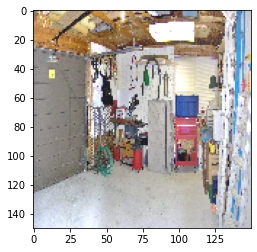

In [17]:
show_sample(0)

laboratorywet


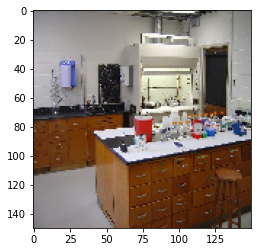

In [18]:
show_sample(1)

bookstore


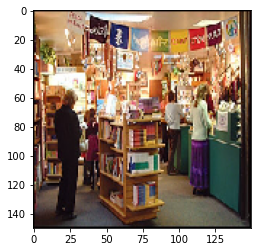

In [19]:
show_sample(2)

<h3>Model</h3>

We'll use a previously trained network (VGG16) that was trained on ImageNet dataset. It'll constitute the convolutional base of our convolutional neural network, then we'll add densely connected classifier convenient to our multiclass classification case.

In [20]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

We'll run the convolutional base on the dataset and use that output as input to densely connected classifier. This is the fast way of feature extraction that won't allow us to do data augmentation.

In [23]:
def extract_features(directory, sample_count, batch_size=20):
     features = np.zeros(shape=(sample_count, 4, 4, 512))
     # VGG16's final layer outputs feature maps of shape (4,4,512)
     labels = np.zeros(shape=(sample_count,67))
     generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
         directory, target_size=(150, 150), batch_size=20, class_mode='categorical')
     i = 0 # iterating over each bach
     for inputs_batch, labels_batch in generator:
         features_batch = conv_base.predict(inputs_batch)
         features[i * batch_size : (i+1) * batch_size] = features_batch
         labels[i * batch_size : (i+1) * batch_size] = labels_batch
         i += 1
         if i * batch_size >= sample_count:
             break
     return features, labels

In [24]:
train_features, train_labels = extract_features(train_dir, 5360)
test_features, test_labels = extract_features(test_dir, 1340)

Found 5360 images belonging to 67 classes.
Found 1340 images belonging to 67 classes.


Flattening arrays:

In [25]:
train_features = np.reshape(train_features, (5360, 4*4* 512))
np.save('train_features.npy', train_features)
test_features = np.reshape(test_features, (1340, 4*4* 512))
np.save('test_features.npy', test_features)

In [26]:
model1 = models.Sequential()
model1.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model1.add(layers.Dense(67, activation='softmax'))

In [27]:
model1.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='categorical_crossentropy', metrics=['acc'])

C:\Users\tlgru\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [28]:
history = model1.fit(train_features, train_labels, epochs=100, batch_size=20)
model1.save('indoors1.h5')

Epoch 1/100
268/268 [==============================] - 2s 5ms/step - loss: 4.1710 - acc: 0.0349
Epoch 2/100
268/268 [==============================] - 1s 5ms/step - loss: 3.8580 - acc: 0.1341A: 0s - loss: 3.8749 - acc: 0.
Epoch 3/100
268/268 [==============================] - 1s 5ms/step - loss: 3.5612 - acc: 0.2289
Epoch 4/100
268/268 [==============================] - 1s 5ms/step - loss: 3.2768 - acc: 0.3106
Epoch 5/100
268/268 [==============================] - 1s 5ms/step - loss: 3.0259 - acc: 0.3733
Epoch 6/100
268/268 [==============================] - 1s 5ms/step - loss: 2.8066 - acc: 0.4207
Epoch 7/100
268/268 [==============================] - 1s 5ms/step - loss: 2.6156 - acc: 0.4610
Epoch 8/100
268/268 [==============================] - 1s 5ms/step - loss: 2.4492 - acc: 0.5015
Epoch 9/100
268/268 [==============================] - 1s 5ms/step - loss: 2.2997 - acc: 0.5306A: 0s - loss: 2.2998 
Epoch 10/100
268/268 [==============================] - 1s 5ms/step - loss: 2.1662 - 

268/268 [==============================] - 1s 5ms/step - loss: 0.0370 - acc: 0.9985A: 0s - loss: 0.0371 - acc: 0.9
Epoch 81/100
268/268 [==============================] - 1s 5ms/step - loss: 0.0345 - acc: 0.9981
Epoch 82/100
268/268 [==============================] - 1s 5ms/step - loss: 0.0322 - acc: 0.9985
Epoch 83/100
268/268 [==============================] - 1s 5ms/step - loss: 0.0299 - acc: 0.9987
Epoch 84/100
268/268 [==============================] - 1s 5ms/step - loss: 0.0280 - acc: 0.9985
Epoch 85/100
268/268 [==============================] - 1s 5ms/step - loss: 0.0266 - acc: 0.9985
Epoch 86/100
268/268 [==============================] - 1s 5ms/step - loss: 0.0246 - acc: 0.9985
Epoch 87/100
268/268 [==============================] - 1s 5ms/step - loss: 0.0230 - acc: 0.9985
Epoch 88/100
268/268 [==============================] - 1s 5ms/step - loss: 0.0218 - acc: 0.9985
Epoch 89/100
268/268 [==============================] - 1s 5ms/step - loss: 0.0205 - acc: 0.9985
Epoch 90/100

In [29]:
test_loss1, test_acc1 = model1.evaluate(test_features, test_labels)

print('test loss:', test_loss1)
print('test acc:', test_acc1)

42/42 [==============================] - 0s 2ms/step - loss: 2.4986 - acc: 0.4455
test loss: 2.4985673427581787
test acc: 0.44552239775657654


Another way for feature extraction is to add & freeze the convolutional base from VGG16 and run it all on input data; which allows us to augment data.

In [30]:
model2 = models.Sequential()
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(67, activation='softmax'))

In [31]:
conv_base.trainable = False

<h3>Data augmentation</h3>

In [32]:
train_datagen_augment = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, 
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

In [33]:
train_generator_augment = train_datagen_augment.flow_from_directory(train_dir, target_size=(150, 150),
                                                    batch_size=20, class_mode='categorical')

Found 5360 images belonging to 67 classes.


In [34]:
model2.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='categorical_crossentropy', metrics=['acc'])

In [35]:
history = model2.fit_generator(train_generator_augment, steps_per_epoch=268, epochs=100)
model2.save('indoors2.h5')

C:\Users\tlgru\anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
268/268 [==============================] - 45s 165ms/step - loss: 4.2252 - acc: 0.0224
Epoch 2/100
268/268 [==============================] - 44s 165ms/step - loss: 4.0828 - acc: 0.0509
Epoch 3/100
268/268 [==============================] - 45s 166ms/step - loss: 3.9412 - acc: 0.0866
Epoch 4/100
268/268 [==============================] - 44s 165ms/step - loss: 3.8081 - acc: 0.1213
Epoch 5/100
268/268 [==============================] - 44s 165ms/step - loss: 3.6769 - acc: 0.15433s - l
Epoch 6/100
268/268 [==============================] - 44s 166ms/step - loss: 3.5681 - acc: 0.1810
Epoch 7/100
268/268 [==============================] - 44s 165ms/step - loss: 3.4554 - acc: 0.2095
Epoch 8/100
268/268 [==============================] - 44s 165ms/step - loss: 3.3693 - acc: 0.2243
Epoch 9/100
268/268 [==============================] - 44s 166ms/step - loss: 3.2840 - acc: 0.2308
Epoch 10/100
268/268 [==============================] - 44s 165ms/step - loss: 3.1942 - acc: 0.2528
Epo

268/268 [==============================] - 45s 169ms/step - loss: 1.8874 - acc: 0.5028
Epoch 80/100
268/268 [==============================] - 47s 173ms/step - loss: 1.8679 - acc: 0.5155
Epoch 81/100
268/268 [==============================] - 45s 168ms/step - loss: 1.8776 - acc: 0.5065
Epoch 82/100
268/268 [==============================] - 47s 175ms/step - loss: 1.8858 - acc: 0.5183
Epoch 83/100
268/268 [==============================] - 46s 170ms/step - loss: 1.8505 - acc: 0.5166
Epoch 84/100
268/268 [==============================] - 46s 173ms/step - loss: 1.8649 - acc: 0.51400s - loss: 1.8622 - acc: 0.
Epoch 85/100
268/268 [==============================] - 46s 172ms/step - loss: 1.8352 - acc: 0.5168
Epoch 86/100
268/268 [==============================] - 46s 170ms/step - loss: 1.8477 - acc: 0.5162
Epoch 87/100
268/268 [==============================] - 46s 171ms/step - loss: 1.8139 - acc: 0.5291
Epoch 88/100
268/268 [==============================] - 46s 170ms/step - loss: 1.8245 

In [36]:
test_loss2, test_acc2 = model2.evaluate(test_generator)

print('test loss:', test_loss2)
print('test acc:', test_acc2)

67/67 [==============================] - 9s 132ms/step - loss: 2.0889 - acc: 0.4448
test loss: 2.088942527770996
test acc: 0.44477611780166626


train accuracy (after final epoch): 0.5353 <br>
test accuracy: 0.4335

Here are some of the predictions from the last model we built: 

In [37]:
img_test, label_test = test_generator.next()

In [38]:
def show_prediction(i): 
    # show prediction for first batch's i-th sample
    pred = model2.predict(img_test)[i]
    label_code = list(pred).index(pred.max())
    plt.imshow(img_test[i])
    print('Class:', labels[list(label_test[i]).index(1)], 'Predicted class:', labels[label_code])

Class: deli Predicted class: videostore


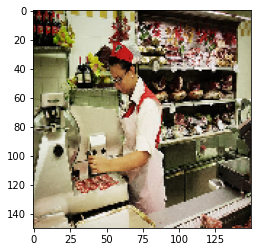

In [42]:
show_prediction(0)

Class: livingroom Predicted class: livingroom


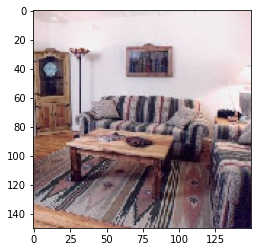

In [44]:
show_prediction(4)

Class: pantry Predicted class: dining_room


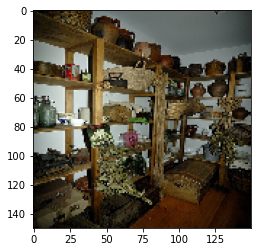

In [45]:
show_prediction(6)

Class: corridor Predicted class: corridor


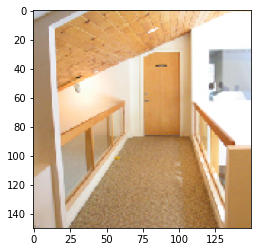

In [47]:
show_prediction(10)